In [1]:
from inclLSTM import IncLSTMDual
import joblib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2026-01-25 18:05:04.175268: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-25 18:05:04.187070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-25 18:05:04.590003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-25 18:05:07.843941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
def prepare_inference_data(df, scalers, lookback=192, horizon=96):
    all_X_past, all_X_fut, all_y, all_t = [], [], [], []

    cols_past = ['AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour_sin', 'hour_cos']
    cols_fut = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour_sin', 'hour_cos']
    target = 'AC_POWER'

    scaler_past = scalers['scaler_past']
    scaler_fut = scalers['scaler_fut']
    scaler_target = scalers['scaler_target']

    data_past_scaled = scaler_past.transform(df[cols_past])
    data_fut_scaled = scaler_fut.transform(df[cols_fut])
    data_target_scaled = scaler_target.transform(df[[target]])

    for inv in df['SOURCE_KEY'].unique():
        inv_mask = (df['SOURCE_KEY'] == inv)
        inv_idx = np.where(inv_mask)[0]

        d_p = data_past_scaled[inv_idx]
        d_f = data_fut_scaled[inv_idx]
        d_t = data_target_scaled[inv_idx]
        time_vals = df.iloc[inv_idx]['DATE_TIME'].values

        n_samples = len(d_p) - lookback - horizon + 1
        if n_samples > 0:
            idx_p = np.arange(n_samples)[:, None] + np.arange(lookback)[None, :]
            all_X_past.append(d_p[idx_p])

            idx_f = np.arange(n_samples)[:, None] + np.arange(lookback, lookback + horizon)[None, :]
            all_X_fut.append(d_f[idx_f])

            all_y.append(d_t[idx_f].squeeze())
            all_t.append(time_vals[np.arange(lookback, len(d_p) - horizon + 1)])

    X_past = np.concatenate(all_X_past)
    X_fut = np.concatenate(all_X_fut)
    y = np.concatenate(all_y)
    t = np.concatenate(all_t)

    sort_idx = np.argsort(t)
    return X_past[sort_idx], X_fut[sort_idx], y[sort_idx], t[sort_idx]

Loading Model from final_solar_model...


2026-01-25 18:05:11.089035: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/endriu/Desktop/MAL_Project/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/endriu/Desktop/MAL_Project/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


System loaded from: final_solar_model (5 models)
Loading Scalers from solar_scalers.pkl...
Loading and Processing Data...


/home/endriu/Desktop/MAL_Project/.venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Isolating Test Data after: 2020-06-16 00:00:00
Test Samples Found: 2112
Running Prediction...
FINAL TEST RESULT (Last 24h)
MAE: 48.76 kW


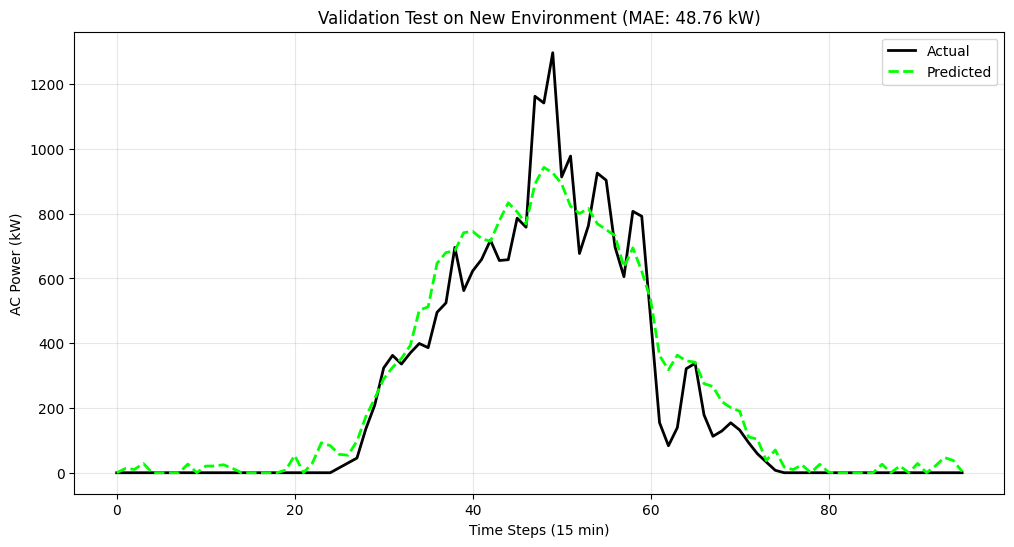

In [3]:
keras.config.enable_unsafe_deserialization()

MODEL_DIR = "final_solar_model"
SCALER_FILE = "solar_scalers.pkl"
DATA_FILE = "cleaned_data/solar_1.csv"
LOOKBACK = 96 * 2
HORIZON = 96

print(f"Loading Model from {MODEL_DIR}...")
model = IncLSTMDual.load_system(MODEL_DIR)

print(f"Loading Scalers from {SCALER_FILE}...")
scalers = joblib.load(SCALER_FILE)

print("Loading and Processing Data...")
df = pd.read_csv(DATA_FILE)
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['hour_sin'] = np.sin(2 * np.pi * df['DATE_TIME'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['DATE_TIME'].dt.hour / 24)

X_all_p, X_all_f, y_all, t_all = prepare_inference_data(df, scalers, LOOKBACK, HORIZON)

last_timestamp = pd.to_datetime(t_all[-1])
cutoff_timestamp = last_timestamp - pd.Timedelta(hours=24)

print(f"\nIsolating Test Data after: {cutoff_timestamp}")
test_mask = t_all > cutoff_timestamp

X_test_p = X_all_p[test_mask]
X_test_f = X_all_f[test_mask]
y_test = y_all[test_mask]

print(f"Test Samples Found: {len(y_test)}")

print("Running Prediction...")
pred_test_norm = model.predict(X_test_p, X_test_f)
pred_test_norm = np.maximum(pred_test_norm, 0)

t_scaler = scalers['scaler_target']
pred_test_real = t_scaler.inverse_transform(pred_test_norm)
y_test_real = t_scaler.inverse_transform(y_test)

mae_test = np.mean(np.abs(pred_test_real - y_test_real))
print(f"FINAL TEST RESULT (Last 24h)")
print(f"MAE: {mae_test:.2f} kW")

plt.figure(figsize=(12, 6))
plt.plot(y_test_real[-1], label='Actual', color='black', linewidth=2)
plt.plot(pred_test_real[-1], label='Predicted', color='lime', linestyle='--', linewidth=2)
plt.title(f"Validation Test on New Environment (MAE: {mae_test:.2f} kW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("Time Steps (15 min)")
plt.ylabel("AC Power (kW)")
plt.show()